In [1]:
!pip install mesa==0.8.9


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 668.9/668.9 kB 14.9 MB/s eta 0:00:00


In [2]:
import random
import numpy as np
import pandas as pd
from mesa import Agent, Model
from mesa.time import RandomActivation


In [3]:
print(RandomActivation)


<class 'mesa.time.RandomActivation'>


In [4]:
class Person(Agent):
    def __init__(self, unique_id, model, state):
        super().__init__(unique_id, model)
        self.state = state

    def step(self):
        if self.state == "I":
            if random.random() < self.model.recovery_rate:
                self.state = "R"
        elif self.state == "S":
            if random.random() < self.model.infection_rate:
                self.state = "I"


In [5]:
class DiseaseModel(Model):
    def __init__(self, population, infection_rate, recovery_rate, initial_infected):
        self.population = population
        self.infection_rate = infection_rate
        self.recovery_rate = recovery_rate
        self.schedule = RandomActivation(self)

        for i in range(population):
            state = "I" if i < initial_infected else "S"
            agent = Person(i, self, state)
            self.schedule.add(agent)

    def step(self):
        self.schedule.step()

    def count_infected(self):
        return sum(1 for a in self.schedule.agents if a.state == "I")


In [6]:
PARAM_BOUNDS = {
    "population": (50, 300),
    "infection_rate": (0.05, 0.9),
    "recovery_rate": (0.01, 0.5),
    "initial_infected": (1, 20),
    "steps": (50, 200)
}


In [7]:
population = random.randint(*PARAM_BOUNDS["population"])
infection_rate = random.uniform(*PARAM_BOUNDS["infection_rate"])
recovery_rate = random.uniform(*PARAM_BOUNDS["recovery_rate"])
initial_infected = random.randint(*PARAM_BOUNDS["initial_infected"])
steps = random.randint(*PARAM_BOUNDS["steps"])

population, infection_rate, recovery_rate, initial_infected, steps


(171, 0.24141825915457948, 0.3234576490829799, 2, 118)

In [8]:
model = DiseaseModel(
    population=population,
    infection_rate=infection_rate,
    recovery_rate=recovery_rate,
    initial_infected=initial_infected
)

peak_infected = 0

for _ in range(steps):
    model.step()
    peak_infected = max(peak_infected, model.count_infected())

peak_infected


68

In [9]:
records = []

for _ in range(1000):
    population = random.randint(*PARAM_BOUNDS["population"])
    infection_rate = random.uniform(*PARAM_BOUNDS["infection_rate"])
    recovery_rate = random.uniform(*PARAM_BOUNDS["recovery_rate"])
    initial_infected = random.randint(*PARAM_BOUNDS["initial_infected"])
    steps = random.randint(*PARAM_BOUNDS["steps"])

    model = DiseaseModel(
        population=population,
        infection_rate=infection_rate,
        recovery_rate=recovery_rate,
        initial_infected=initial_infected
    )

    peak_infected = 0
    for _ in range(steps):
        model.step()
        peak_infected = max(peak_infected, model.count_infected())

    records.append([
        population,
        infection_rate,
        recovery_rate,
        initial_infected,
        steps,
        peak_infected
    ])


In [10]:
df_sim = pd.DataFrame(
    records,
    columns=[
        "population",
        "infection_rate",
        "recovery_rate",
        "initial_infected",
        "steps",
        "peak_infected"
    ]
)

df_sim.head()


,population,infection_rate,recovery_rate,initial_infected,steps,peak_infected
0,197,0.822159,0.416320,11,91,165
1,140,0.109830,0.283565,17,109,37
2,275,0.219675,0.201811,10,149,122
3,200,0.393523,0.277372,10,191,112
4,147,0.390897,0.055812,15,199,120


In [11]:
df_sim.to_csv("simulation_data.csv", index=False)


In [12]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor


In [13]:
X = df_sim.drop("peak_infected", axis=1)
y = df_sim["peak_infected"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [14]:
models = {
    "Linear Regression": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor(),
    "Random Forest": RandomForestRegressor(),
    "Gradient Boosting": GradientBoostingRegressor(),
    "Support Vector Regressor": SVR(),
    "K-Nearest Neighbors": KNeighborsRegressor()
}


In [15]:
results = []

for name, model in models.items():
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)

    r2 = r2_score(y_test, predictions)
    mse = mean_squared_error(y_test, predictions)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, predictions)

    results.append([name, r2, rmse, mae])


In [16]:
df_results = pd.DataFrame(
    results,
    columns=["Model", "R2_Score", "RMSE", "MAE"]
)

df_results.sort_values("R2_Score", ascending=False)


,Model,R2_Score,RMSE,MAE
3,Gradient Boosting,0.980871,8.181501,6.265797
2,Random Forest,0.978325,8.709069,6.735400
1,Decision Tree,0.938059,14.722432,10.920000
0,Linear Regression,0.896303,19.049008,14.195120
4,Support Vector Regressor,0.530298,40.541526,31.389997
5,K-Nearest Neighbors,0.449627,43.885130,32.943000


In [17]:
df_results.to_csv("model_comparison.csv", index=False)


In [18]:
import matplotlib.pyplot as plt


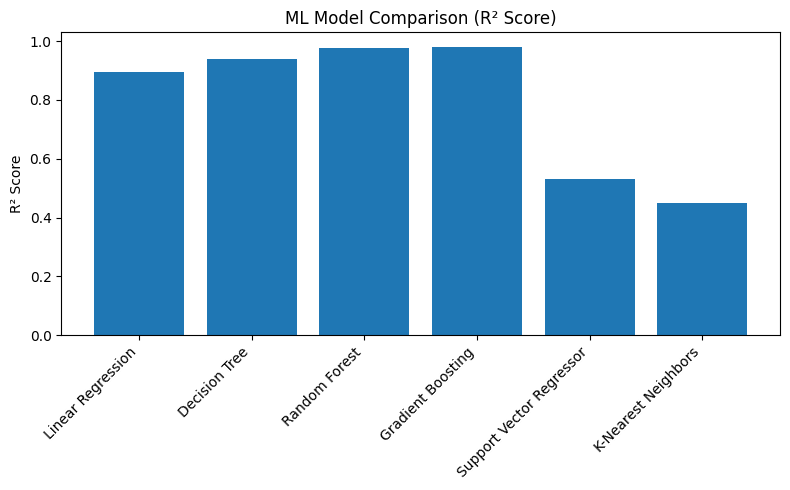

In [19]:
plt.figure(figsize=(8, 5))
plt.bar(df_results["Model"], df_results["R2_Score"])
plt.xticks(rotation=45, ha="right")
plt.ylabel("R² Score")
plt.title("ML Model Comparison (R² Score)")
plt.tight_layout()
plt.savefig("model_r2_comparison.png")
plt.show()


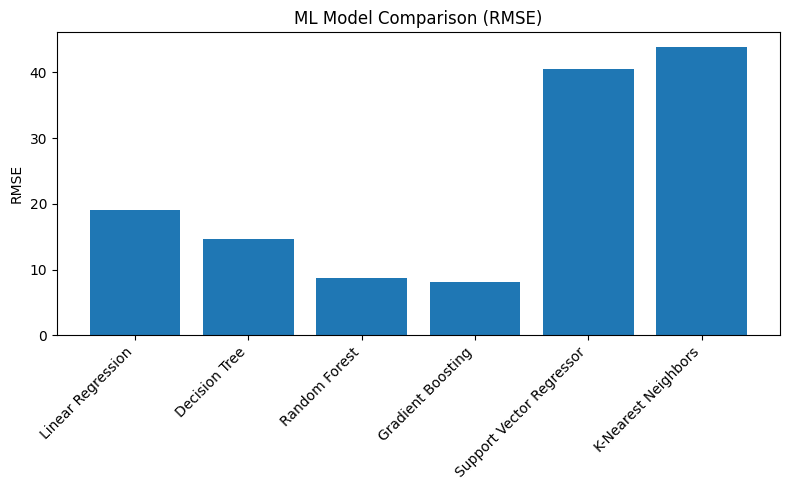

In [20]:
plt.figure(figsize=(8, 5))
plt.bar(df_results["Model"], df_results["RMSE"])
plt.xticks(rotation=45, ha="right")
plt.ylabel("RMSE")
plt.title("ML Model Comparison (RMSE)")
plt.tight_layout()
plt.savefig("model_rmse_comparison.png")
plt.show()


In [21]:
import os
os.listdir()


['.config',
 'simulation_data.csv',
 'model_comparison.csv',
 'model_r2_comparison.png',
 'model_rmse_comparison.png',
 'sample_data']

In [22]:
from google.colab import files

files.download("simulation_data.csv")
files.download("model_comparison.csv")
files.download("model_r2_comparison.png")
files.download("model_rmse_comparison.png")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>